# Landing Performance Assignment

In [47]:
import math
import qty
import numpy as np
import pandas as pd
import atmosphere as atm
import matplotlib.pyplot as plt

## Deliverable 1 - Dispatch Landing Chart

### Conditions:
- Dry AND wet runways
- Mass variation from 170 to 230 tons, steps of 10 tons
- Field elevation sea level, up to and including 5000 ft, steps of 1000 ft
- Zero wind

### Aircraft data
- Wingspan, $b = 64.5 m$
- Wing surface, $S = 436.8 m^2$
- Oswald factor, $e = 0.8$
- Parasitic drag coefficient in landing configuration, $C_{D_0} = 0.088$
- Braking coefficient on dry runway, $\mu_{dry} = 0.54$
- Braking coefficient on wet runway, $\mu_{wet} = 0.34$
- Lift coefficient in ground run, $C_{L_{gnd}} = 0.126$
- Drag coefficient in ground run, $C_{D_{gnd}} = 0.213$
- IAS stall at 200 tons with flaps 30, ${IAS}_{stall} = 122 Kts$
- Speed during approach, $v_{ref} = 1.23 \cdot {IAS}_{stall}$
- Speed at touchdown, $v_{td} = 1.18 \cdot {IAS}_{stall}$
- Time of transition phase, $t_{tr} = 1.3 s$
- Speed decay factor of transition phase of landing run, $decay = 0.85$
- Thrust per engine at touchdown, $T = 3400 lbs$

### Assumptions
- Landing flaps 30
- Drag polar is exactly parabolic

Initialize the variables in python:

In [48]:
wingspan = qty.Distance(64.5)
surface = qty.Area(436.8)
oswald = 0.8
cd0_land = 0.088
mu_dry = 0.54
mu_wet = 0.34
cl_gnd = 0.126
cd_gnd = 0.213
ias_stall = qty.Velocity.Kts(122)
v_stall_to_ref = 1.23
v_stall_to_td = 1.18
transition_time = qty.Time(1.3)
speed_decay = 0.85
thrust_td = qty.Force.Lbf(3400 * 2)

# Modern aircraft, so flare height = screen height = 50 ft
flare_height = qty.Distance.Ft(50)

# Assume ILS approach, 3 degrees fpa
fpa = math.radians(3)

Calculate the k-constant of the aircraft, as part of:\
$C_D = C_{D_0} + k \cdot C_L^2$

where\
$\large k = \frac{1}{\pi \cdot e \cdot AR}$

In [49]:
aspect_ratio = wingspan**2 / surface
k_const = 1 / (math.pi * oswald * aspect_ratio)

k_const

0.04177566200501165

Calculate the $C_{L_{max}}$ of the aircraft, using the given stall speed at 200 tons. $IAS$ is equal to $TAS$ at, sea level, so this value can be used.

In [50]:
cl_max = (2 * 9.81 * 200000) / (1.225 * ias_stall**2 * surface)

cl_max

1.8617169631927402

With the value for $C_{L_{max}}$, speeds needed for the calculations can be calculated for a given mass and elevation height. The function below takes in a given mass and elevation height, both is SI-units, and returns in order:

Reference/Approach speed, Touchdown speed, Stall speed.

All values are in SI-units ($\frac{m}{s}$).

In [51]:
def get_tas(weight: qty.Force, elevation: qty.Distance) -> tuple[qty.Velocity, qty.Velocity, qty.Velocity, qty.Velocity]:
    """
    Returns the true air speed of (Ref Speed, Touchdown Speed, Brakes-on Speed, Stall Speed) in m/s.
    """
    
    density = atm.get_density(elevation)
    ias_stall = math.sqrt((2 * weight) / (surface * cl_max * density))
    v_stall = qty.Velocity(ias_stall * math.sqrt(1.225 / density))
    v_ref = qty.Velocity(v_stall * v_stall_to_ref)
    v_td = qty.Velocity(v_stall  * v_stall_to_td)
    v_bo = qty.Velocity(v_td * speed_decay)
    
    return v_ref, v_td, v_bo, v_stall

The distance of the flare part of the approach can be calculated using the following function:

$ \large S_B = \frac{\frac{W}{2g}({TAS}_C^2 - {TAS}_B^2) - W \cdot h_f}{T - D} $

where (T -D) is the average between point B and C. Point B is at the start of the flare:

$ D - T = W \cdot \sin{\gamma} $

To calculate the flare distance on the approach, two functions can be defined. The first one calculates $(T - D)_{avg}$ during the flare. Let's call this function `get_flare_tmind`. Using this value, the flare distane can be obtained using the first function above. The values for ${TAS}_B$ and ${TAS}_C$ are obtained using the `get_tas` function defined earlier. The weight value is obtained by converting any given weight to gravitational force, and any other value is defined earlier.

In [52]:
def get_flare_dist(weight: qty.Force, elevation: qty.Distance, v_ref: qty.Velocity, v_td: qty.Velocity) -> qty.Distance:
    """
    Returns the approximate flare distance in meters.
    """
    
    tmind_avg = get_flare_tmind(weight, elevation, v_td)
    dist_flare = qty.Distance((weight / (2 * 9.81) * (v_td**2 - v_ref**2) - weight * flare_height) / tmind_avg)
    
    return dist_flare

def get_flare_tmind(weight: qty.Force, elevation: qty.Distance, v_td: qty.Velocity) -> qty.Force:
    """
    returns the average value for (T - D) during the flare.
    """
    
    density = atm.get_density(elevation)
    drag_td = qty.Force(0.5 * density * v_td**2 * surface * cd_gnd)
    
    tmind_td = qty.Force(thrust_td - drag_td)
    tmind_app = qty.Force(-(weight * math.sin(fpa)))

    tmind_avg = qty.Force((tmind_app + tmind_td) / 2)
    
    return tmind_avg

The transition distance is obtained by taking the average transition speed (Touchdown speed to Brakes-on speed) and multiplying it by the transition time. The function below returns the transition distance for the given speeds.

In [53]:
def get_trans_dist(v_td: qty.Velocity, v_bo: qty.Velocity) -> qty.Distance:
    """
    Returns the distance travaled withing the transition time, given a touchdown and brakes-on speed. All units are SI-units.
    """
    avg_trans_speed = qty.Velocity((v_td + v_bo) / 2)
    trans_dist = qty.Distance(transition_time * avg_trans_speed)
    
    return trans_dist

The ground run distance can be calculated with a multi-step practical approach:

1. Split the round run up into multiple speed segments. 
2. Calculate the acceleration at the upper speed and lower speed of the segment.
3. Calculate the average speed and acceleration during the segment
4. With the average speed and acceleration, calculate the distance travelled throughout the segment.
5. Add up all segment distances, the total is the approximate ground run distance.

To calculate this in Python, two functions will be defined. The first function `get_brake_dist` takes the brakes-on speed, and divides the ground run into multiple speed segments. For every segment, the second function will be called.

The second function `get_segment_dist` takes the speed bounds of the segment, and calculates the segment distance using the described approach. 

To calculate the acceleration at a given speed. The following equation is used:

$\large a = \frac{g \cdot (T - D - \mu \cdot (W - L))}{W}$

where

$L = \frac{1}{2} \cdot \rho_h \cdot v^2 \cdot S \cdot C_{L_{gnd}}$

and 

$D = \frac{1}{2} \cdot \rho_h \cdot v^2 \cdot S \cdot C_{D_{gnd}}$

# Currently not using this method, scroll down for the other method

In [115]:
from typing import Literal


def get_brake_dist(weight: qty.Force, elevation: qty.Distance, v_bo: qty.Velocity) -> qty.Distance:
    brake_dist_dry = 0
    brake_dist_wet = 0
    
    remaining_speed = int(v_bo.base)
    
    # First, calculate the segment distance for the decimal remainder of the brakes-on speed. After that, iterate over the remaining integer value.
    seg_dry, seg_wet = get_segment_dist((v_bo, remaining_speed), elevation, weight)
    
    brake_dist_dry += seg_dry
    brake_dist_wet += seg_wet
    
    # Now that the remaining speed is a round (integer) value, calculate segments of 1 m/s until the speed is 0.
    while (remaining_speed > 0):
        seg_dry, seg_wet = get_segment_dist((remaining_speed, remaining_speed - 1), elevation, weight)
        
        brake_dist_dry += seg_dry
        brake_dist_wet += seg_wet
        
        remaining_speed -= 1
        
    return (qty.Distance(brake_dist_dry), qty.Distance(brake_dist_wet))
    
def get_segment_dist(speed_bounds: tuple[qty.Velocity, qty.Velocity], elevation: qty.Distance, weight: qty.Force) -> qty.Distance:
    upper, lower = speed_bounds
    density = atm.get_density(elevation)
    
    drag_upper = qty.Force(0.5 * density * upper**2 * surface * cd_gnd)
    drag_lower = qty.Force(0.5 * density * lower**2 * surface * cd_gnd)
    
    lift_upper = qty.Force(0.5 * density * upper**2 * surface * cl_gnd)
    lift_lower = qty.Force(0.5 * density * lower**2 * surface * cl_gnd)
    
    seg_dist_dry = get_delta_dist((lift_upper, lift_lower), (drag_upper, drag_lower), (upper, lower), weight, mu_dry)
    seg_dist_wet = get_delta_dist((lift_upper, lift_lower), (drag_upper, drag_lower), (upper, lower), weight,  mu_wet)
    
    return (seg_dist_dry, seg_dist_wet)

def get_delta_dist(
    lift_bounds: tuple[qty.Force, qty.Force],
    drag_bounds: tuple[qty.Force, qty.Force],
    speed_bounds: tuple[qty.Velocity, qty.Velocity],
    weight: qty.Force,
    mu: float
    ) -> float:
    
    drag_upper, drag_lower = drag_bounds
    lift_upper, lift_lower = lift_bounds
    speed_upper, speed_lower = speed_bounds
    
    accel_upper = (9.81 *  (thrust_td - drag_upper - mu * (weight - lift_upper))) / weight
    accel_lower = (9.81 *  (thrust_td - drag_lower - mu * (weight - lift_lower))) / weight
    
    accel_avg = (accel_upper + accel_lower) / 2
    v_avg = qty.Velocity((speed_upper + speed_lower) / 2)
    delta_v = qty.Velocity(speed_upper - speed_lower)
    segment_dist = qty.Distance(-(v_avg * delta_v / accel_avg))
    
    return segment_dist
    

#### Landing distance approach 2

Equation for ground run distance:

$ \Large S_u = \frac{1}{2 \cdot g \cdot e} \cdot \ln{\frac{d - e \cdot {TAS}_L^2}{d}} $

where

$ \large d = -\mu $

and 

$ \large e = \frac{\rho \cdot S}{2 \cdot W} \cdot (C_D - \mu \cdot C_L) $

To represent this in code, one function can be created that calculates the ground run distance based on the parameters. The function name for this is  `get_ground_run`.

In [116]:
def get_ground_run(weight: qty.Force, elevation: qty.Distance, mu: float, v_bo: qty.Velocity) -> qty.Distance:
    density = atm.get_density(elevation)
    e_value = (density * surface) / (2 * weight) * (cd_gnd - mu * cl_gnd)
    ground_run = qty.Distance(1 / (2 * 9.81 * e_value) * math.log((-mu - e_value*v_bo**2) / -mu))
    
    return ground_run

With functions for the flare distance, transition distance and brake distance defined, the total landing distance can be calculated for every applicable mass and elevation. The cell below loops though every mass from 170 to 230 tons, and every elevation from 0 to 5000 ft. Every obtained landing distance is stored in a dataframe to be plotted later.

In [117]:
masses = [qty.Mass.M_ton(m) for m in np.arange(170, 240, 10)]
elevations = [qty.Distance.Ft(h) for h in np.arange(0, 6000, 1000)]

df = pd.DataFrame(columns=["mass", "elevation", "dist_dry", "dist_wet"])

for mass in masses:
    for elev in elevations:
        weight = qty.Force.Kg(mass)
        v_ref, v_td, v_bo, v_stall = get_tas(weight, elev)

        
        dist_flare = get_flare_dist(weight, elev, v_ref, v_td)
        dist_trans = get_trans_dist(v_td, v_bo)
        dist_brake_dry = get_ground_run(weight, elev, mu_dry, v_bo)
        dist_brake_wet = get_ground_run(weight, elev, mu_wet, v_bo)

        dist_total_dry = qty.Distance(dist_flare + dist_trans + dist_brake_dry)
        dist_total_wet = qty.Distance(dist_flare + dist_trans + dist_brake_wet)
        
        df.loc[len(df)] = {
            "mass": int(mass.m_ton),
            "elevation": int(elev.ft),
            "dist_dry": float(dist_total_dry.base),
            "dist_wet": float(dist_total_wet.base)
        }
df

,mass,elevation,dist_dry,dist_wet
0,170,0,748.723611,898.660804
1,170,1000,772.205485,930.267430
2,170,2000,797.241481,963.904540
3,170,3000,823.929622,999.699722
4,170,4000,852.375011,1037.789538
5,170,5000,882.690399,1078.320218
6,180,0,779.067911,937.824939
7,180,1000,804.106500,971.466207
8,180,2000,830.783891,1007.250659
9,180,3000,859.203744,1045.313262


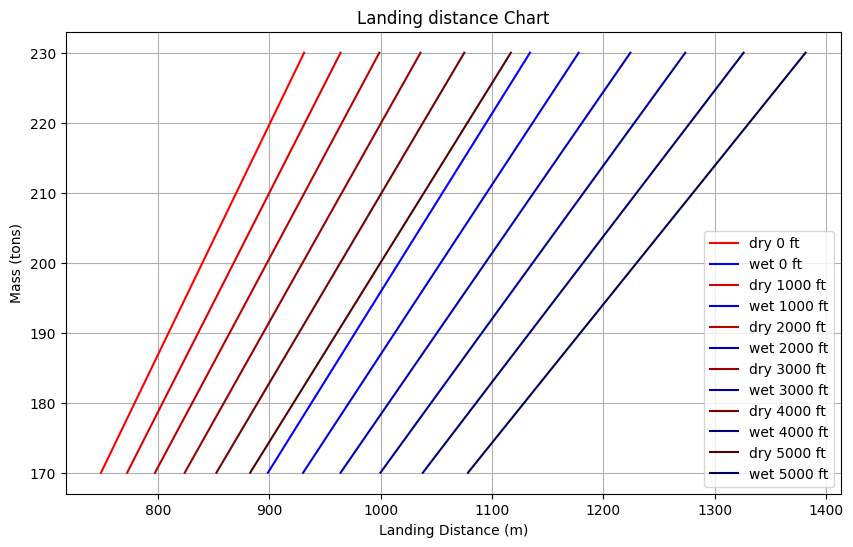

In [121]:
sub = df[df['mass'] == 170]
subsubdf = df[df['mass'] == 180]

colors = {
    0000: ["#FF0000", "#0000FF"],
    1000: ["#DD0000", "#0000DD"],
    2000: ["#BB0000", "#0000BB"],
    3000: ["#990000", "#000099"],
    4000: ["#770000", "#000077"],
    5000: ["#550000", "#000055"],
}

plt.figure(figsize=(10, 6))

for elev in elevations:
    elev = int(elev.ft)
    
    subdf = df[df['elevation'] == elev]

    h = 0
    plt.plot(subdf['dist_dry'], subdf['mass'], label=str(f"dry {elev} ft"), color=colors[elev][0])
    plt.plot(subdf['dist_wet'], subdf['mass'], label=str(f"wet {elev} ft"), color=colors[elev][1])

plt.xlabel('Landing Distance (m)')
plt.ylabel('Mass (tons)')
plt.title("Landing distance Chart")
plt.legend()
plt.grid()
plt.show()

Ugly plot, I know... Just a proof of concept